In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install geotext

In [ ]:
from geotext import GeoText

In [ ]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from gensim.models import Word2Vec, KeyedVectors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import nltk
nltk.download('punkt')
  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 載入Training/ Test Dataset

In [ ]:
train = pd.read_csv('/content/drive/My Drive/Untitled folder/Real_Or_Not/train.csv')
test = pd.read_csv('/content/drive/My Drive/Untitled folder/Real_Or_Not/test.csv')

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# 採用 Google Pretrain W2V model 作為 an embedding layer

In [ ]:
import time

start = time.time()

w2v = KeyedVectors.load_word2vec_format('/content/drive/My Drive/Untitled folder/Real_Or_Not/GoogleNews-vectors-negative300.bin',binary = True )

end = (time.time() - start)/60

print()
print('How long it takes to load the pretrained word2vec model: ', end, 'mins')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL



How long it takes to load the pretrained word2vec model:  0.5642925858497619 mins


# EDA

此 Train 和 Test dataset, Train一共有7613個Tweets, 分別有'id', 'keyword', 'location', 'text', 'target'欄。
Test一共有3263個Tweets, 分別有'id', 'keyword', 'location', 'text'欄。

In [ ]:
print('Train dataset shape: ', train.shape, 'Train columns: ', list(train.columns))
print('Test dataset shape: ', test.shape, 'Test columns: ', list(test.columns))


Train dataset shape:  (7613, 5) Train columns:  ['id', 'keyword', 'location', 'text', 'target']
Test dataset shape:  (3263, 4) Test columns:  ['id', 'keyword', 'location', 'text']


## Real/ Not ratio
#### True: 3271  False: 4342 
#### True/ False 比例: 0.7533  | 這是個分布平均的 Train Dataset

In [ ]:
print('False:', Counter(train.target)[0], 'True:', Counter(train.target)[1], 'Ratio:',  Counter(train.target)[1]/Counter(train.target)[0])
Counter(train.target)

False: 4342 True: 3271 Ratio: 0.7533394748963611


Counter({0: 4342, 1: 3271})

### location, keyword的缺失值

只有location, keyword有缺失值，location在 Train/Test dataset有大概35%的缺失值，keyword 在 Train/Test有小於5%的缺失值。

In [ ]:
train_na = list(train.isnull().sum())
test_na = list(test.isnull().sum())

train_na_ratio = [i/ train.shape[0] for i in train_na]
test_na_ratio = [i/ test.shape[0] for i in test_na]


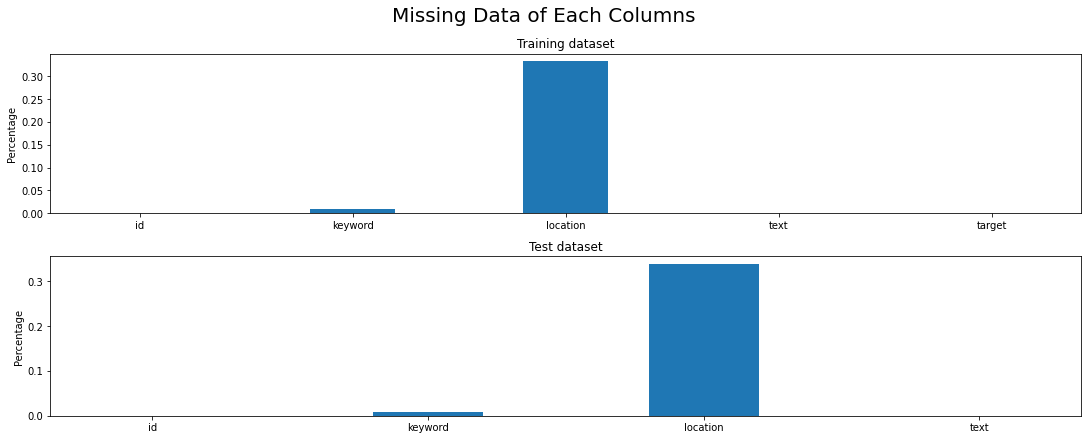

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize = (15, 6), constrained_layout=True)
axes[0].bar(x = list(train.columns), height = train_na_ratio, width = 0.4)
axes[0].set_title('Training dataset')
axes[0].set_ylabel('Percentage')
axes[1].bar(x = list(test.columns), height = test_na_ratio, width = 0.4)
axes[1].set_title('Test dataset')
axes[1].set_ylabel('Percentage')
fig.suptitle('Missing Data of Each Columns', fontsize = 20)

plt.show()

#### Location欄的數據因為是用戶手動輸入，所以混雜且行政的單位不一，例如有些是國家，有些則是城市。

因為有將近35%的缺失值，且單位不一致，在此先不採用這個欄位。

In [ ]:
# Let's check what we got with location column from both train & test dataset
# location data is extremely messy and has more than 30% missing value.

Counter(list(train.location)).most_common(20)

[(nan, 2533),
 ('USA', 104),
 ('New York', 71),
 ('United States', 50),
 ('London', 45),
 ('Canada', 29),
 ('Nigeria', 28),
 ('UK', 27),
 ('Los Angeles, CA', 26),
 ('India', 24),
 ('Mumbai', 22),
 ('Washington, DC', 21),
 ('Kenya', 20),
 ('Worldwide', 19),
 ('Australia', 18),
 ('Chicago, IL', 18),
 ('California', 17),
 ('New York, NY', 15),
 ('California, USA', 15),
 ('Everywhere', 15)]

#### Keyword欄

可以看到keyword在 label True和 label False兩群體間有明顯不同的分布，可以將這個數據作為有用的feature。


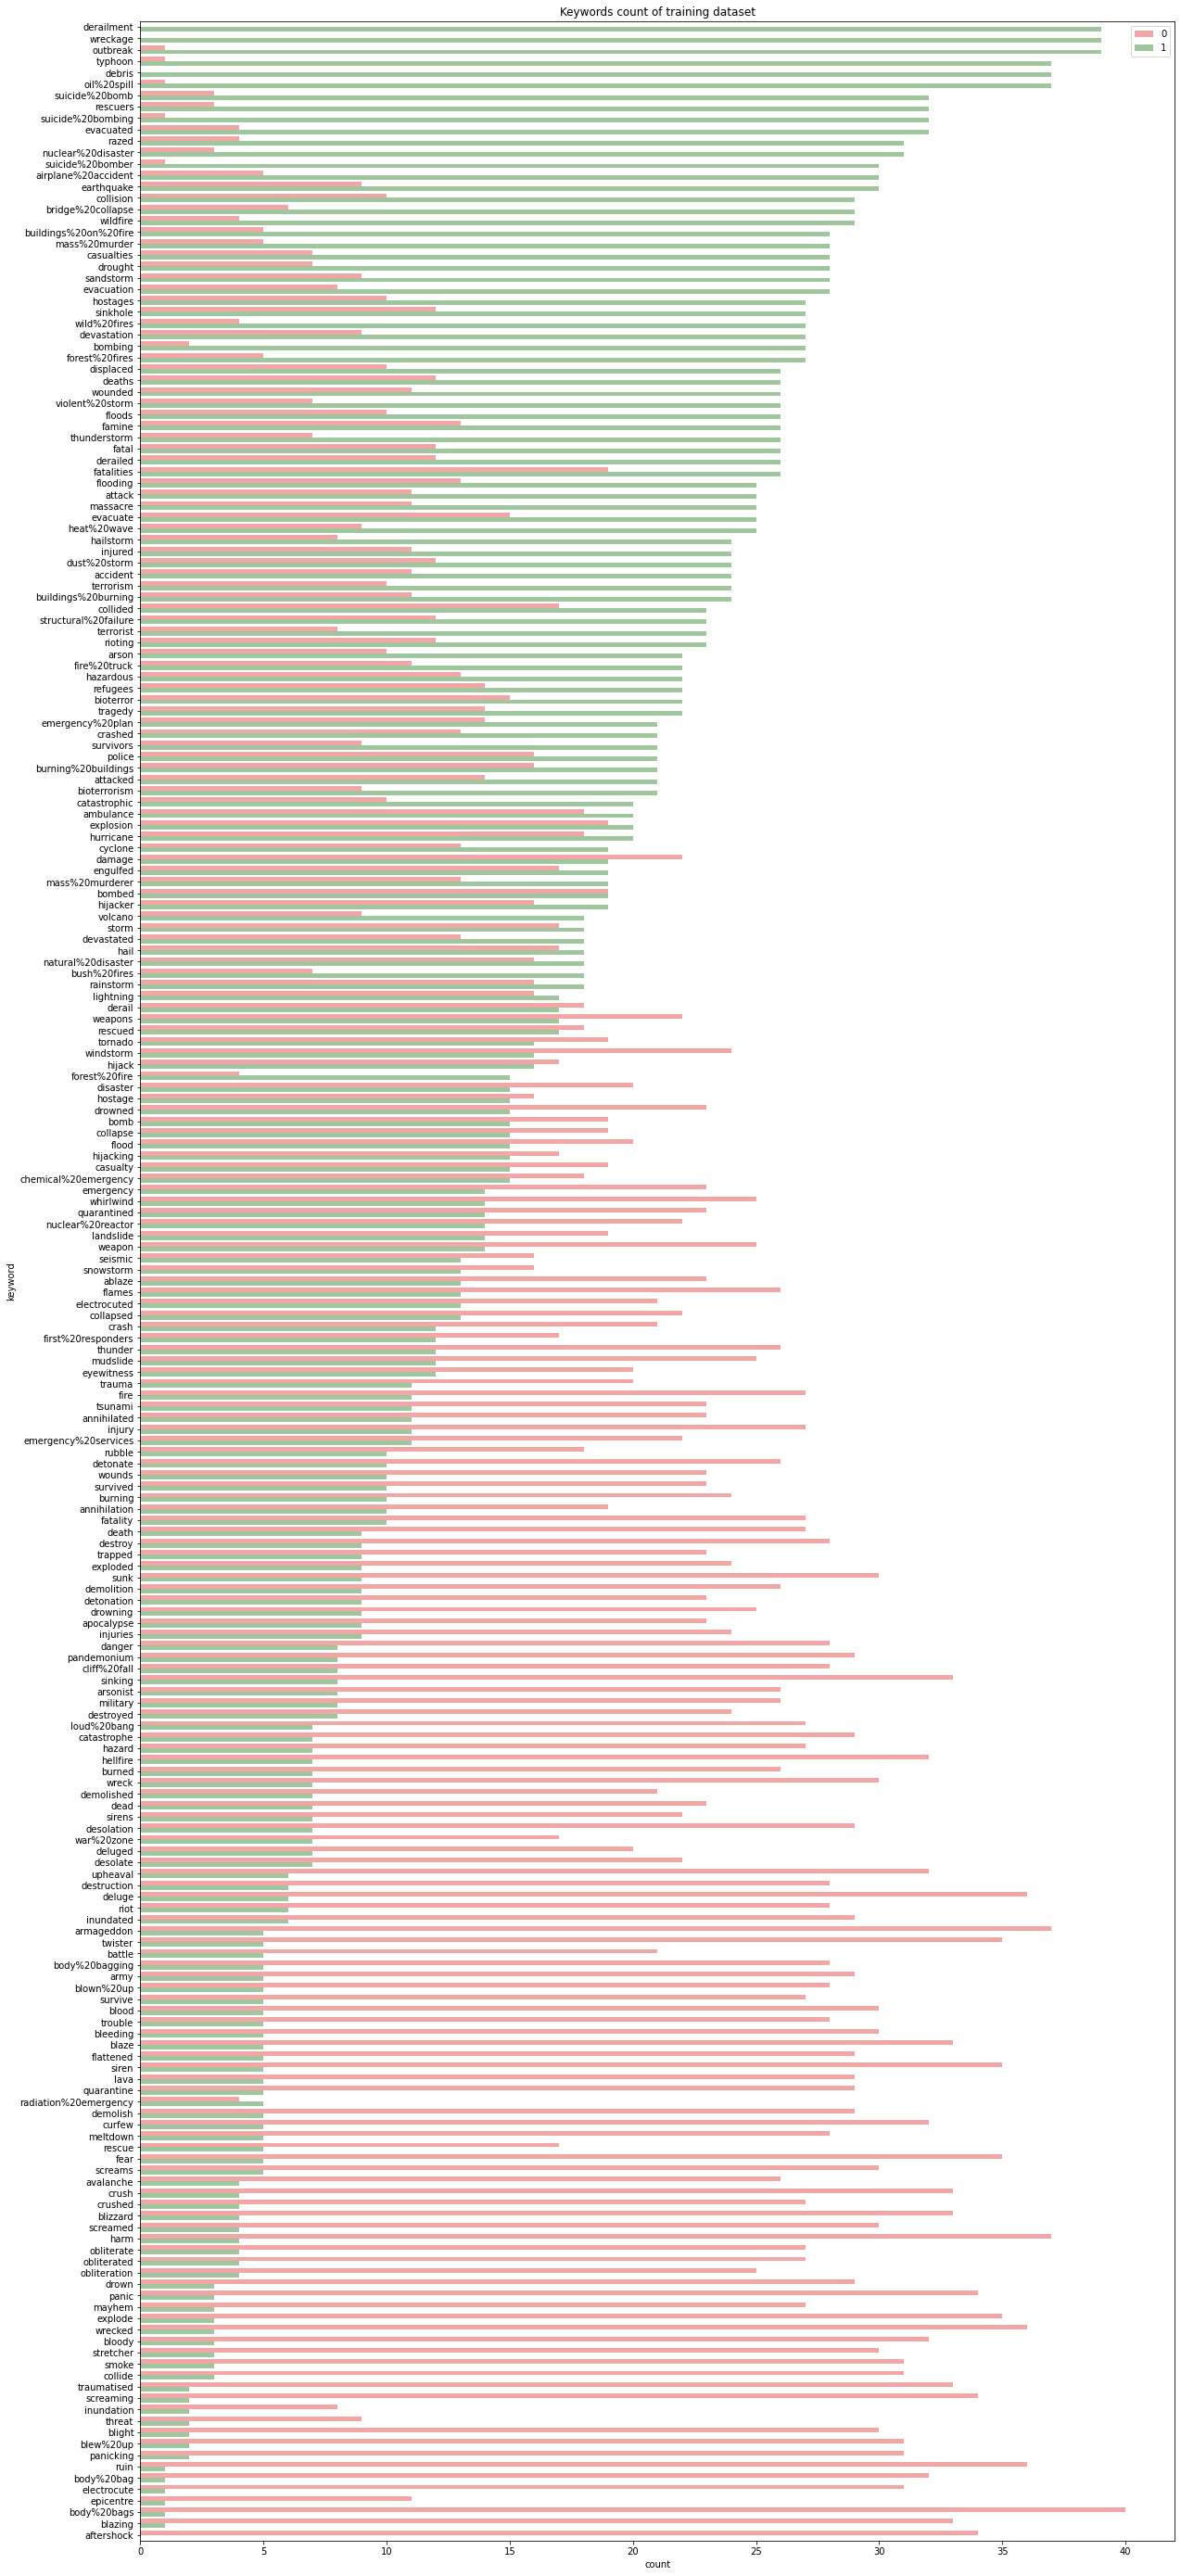

In [ ]:
order = pd.crosstab(train.keyword, train.target).sort_values(1, ascending=False).index

palette ={0:"#FF9999",1:"#99CC99"}

fig, ax = plt.subplots(figsize = (20, 50))
ax = sns.countplot(y="keyword",  
                   palette = palette,                
                  hue="target",
                  data=train,
                  order=order
                 )
plt.legend(loc = 'upper right')
plt.title('Keywords count of training dataset')
plt.show()

從上圖中我們可以看到有些keyword在"real" disaster tweets中出現的次數多很多但是在"fake" disaster中出現的次數非常低，有些則是相反。這些keyword會是模型在分類時有用的依據。

在上圖中，前30以及後30的字，在全部dataset(Train/ Test dataset)的覆蓋率是27%

In [ ]:
c = Counter(list(train.keyword) + list(test.keyword))
cover = 0

# first 30 and last 30 keywords
l =list(order[:31]) + list(order[-30:])
for k in  l:
  cover += c[k]

print('{:.2} coverage of the whole dataset.'.format(cover/ ((train.shape[0]) + test.shape[0])))


0.27 coverage of the whole dataset.


In [ ]:
train_key_f_p = [1 if k in list(order[:31]) else 0 for k in train['keyword']]
train_key_f_n = [1 if k in list(order[-30:]) else 0 for k in train['keyword']]

test_key_f_p = [1 if k in list(order[:31]) else 0 for k in test['keyword']]
test_key_f_n = [1 if k in list(order[-30:]) else 0 for k in test['keyword']]

# 其他的特徵(featrues)

### text中的字數

In [ ]:
# Make a copy of train df

train_fs = train.copy()
test_fs = test.copy()

# Count words in each text

train_fs['word_c'] = [len(t.split(' ')) for t in train_fs.text]
test_fs['word_c'] = [len(t.split(' ')) for t in test_fs.text]

### text中的相異字數

In [ ]:
train_fs['u_word_c'] = [len(set(t.split(' '))) for t in train_fs.text]
test_fs['u_word_c'] = [len(set(t.split(' '))) for t in test_fs.text]

### text中 stopwords 的出現字數 

In [ ]:
nltk.download('stopwords')

s = stopwords.words('english')
train_fs['s_word_c'] = [len([w for w in t.split(' ') if w in s]) for t in train_fs.text] 

test_fs['s_word_c'] = [len([w for w in t.split(' ') if w in s]) for t in test_fs.text] 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### text中是否有 URL

In [ ]:
train_fs['url']= [1 if 'http' in t else 0 for t in train_fs.text] 

test_fs['url']= [1 if 'http' in t else 0 for t in test_fs.text] 

### text中字元數(最長字元數, 總字元數, 平均字元數)

In [ ]:
# max character count

max_word_l = [max([len(w) for w in t.split(' ')])for t in train_fs.text] 

# sum character count

sum_word_l = [sum([len(w) for w in t.split(' ')])for t in train_fs.text] 

# average character count

a_word_l = [np.mean(([len(w) for w in t.split(' ')]))for t in train_fs.text] 




train_fs['max_c']= max_word_l
train_fs['sum_c']= sum_word_l
train_fs['a_c']= a_word_l



# max character count
max_word_l_t = [max([len(w) for w in t.split(' ')])for t in test_fs.text] 

# sum character count
sum_word_l_t = [sum([len(w) for w in t.split(' ')])for t in test_fs.text] 

# average character count
a_word_l_t = [np.mean(([len(w) for w in t.split(' ')]))for t in test_fs.text] 




test_fs['max_c']= max_word_l_t
test_fs['sum_c']= sum_word_l_t
test_fs['a_c']= a_word_l_t

### text中的標點符號數(不計算網址中的符號)

In [ ]:
p = '?!.,"$%\'()*+-:;<=>[\\]^_`{|}~/'

train_fs['pun_c'] = [sum([len([c for c in w if c in p]) for w in t.split(' ') if 'http' not in w]) for t in train_fs.text] 

test_fs['pun_c'] = [sum([len([c for c in w if c in p]) for w in t.split(' ') if 'http' not in w]) for t in test_fs.text] 

### text中Hashtags個數(不計算網址中的符號)

In [ ]:
train_fs['hash'] = [sum([len([c for c in w if c in '#']) for w in t.split(' ') if 'http' not in w]) for t in train_fs.text] 


test_fs['hash'] = [sum([len([c for c in w if c in '#']) for w in t.split(' ') if 'http' not in w]) for t in test_fs.text] 

### text中 "@"個數(不計算網址中的符號)

In [ ]:
train_fs['mention'] = [sum([len([c for c in w if c in '@']) for w in t.split(' ') if 'http' not in w]) for t in train_fs.text] 

test_fs['mention'] = [sum([len([c for c in w if c in '@']) for w in t.split(' ') if 'http' not in w]) for t in test_fs.text] 

### text中是否有提及地名

In [ ]:
train_fs['iflocation']  = [1 if len(GeoText(t).countries) > 0 else 0 for t in train_fs.text]

test_fs['iflocation']  = [1 if len(GeoText(t).countries) > 0 else 0 for t in test_fs.text]

### Visualizaion

In [ ]:
train_fs.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'word_c', 'u_word_c',
       's_word_c', 'url', 'max_c', 'sum_c', 'a_c', 'pun_c', 'hash', 'mention',
       'iflocation'],
      dtype='object')

In [ ]:
train_fs['label'] = ['Not_True' if i == 0 else 'True' for i in train_fs['target']]

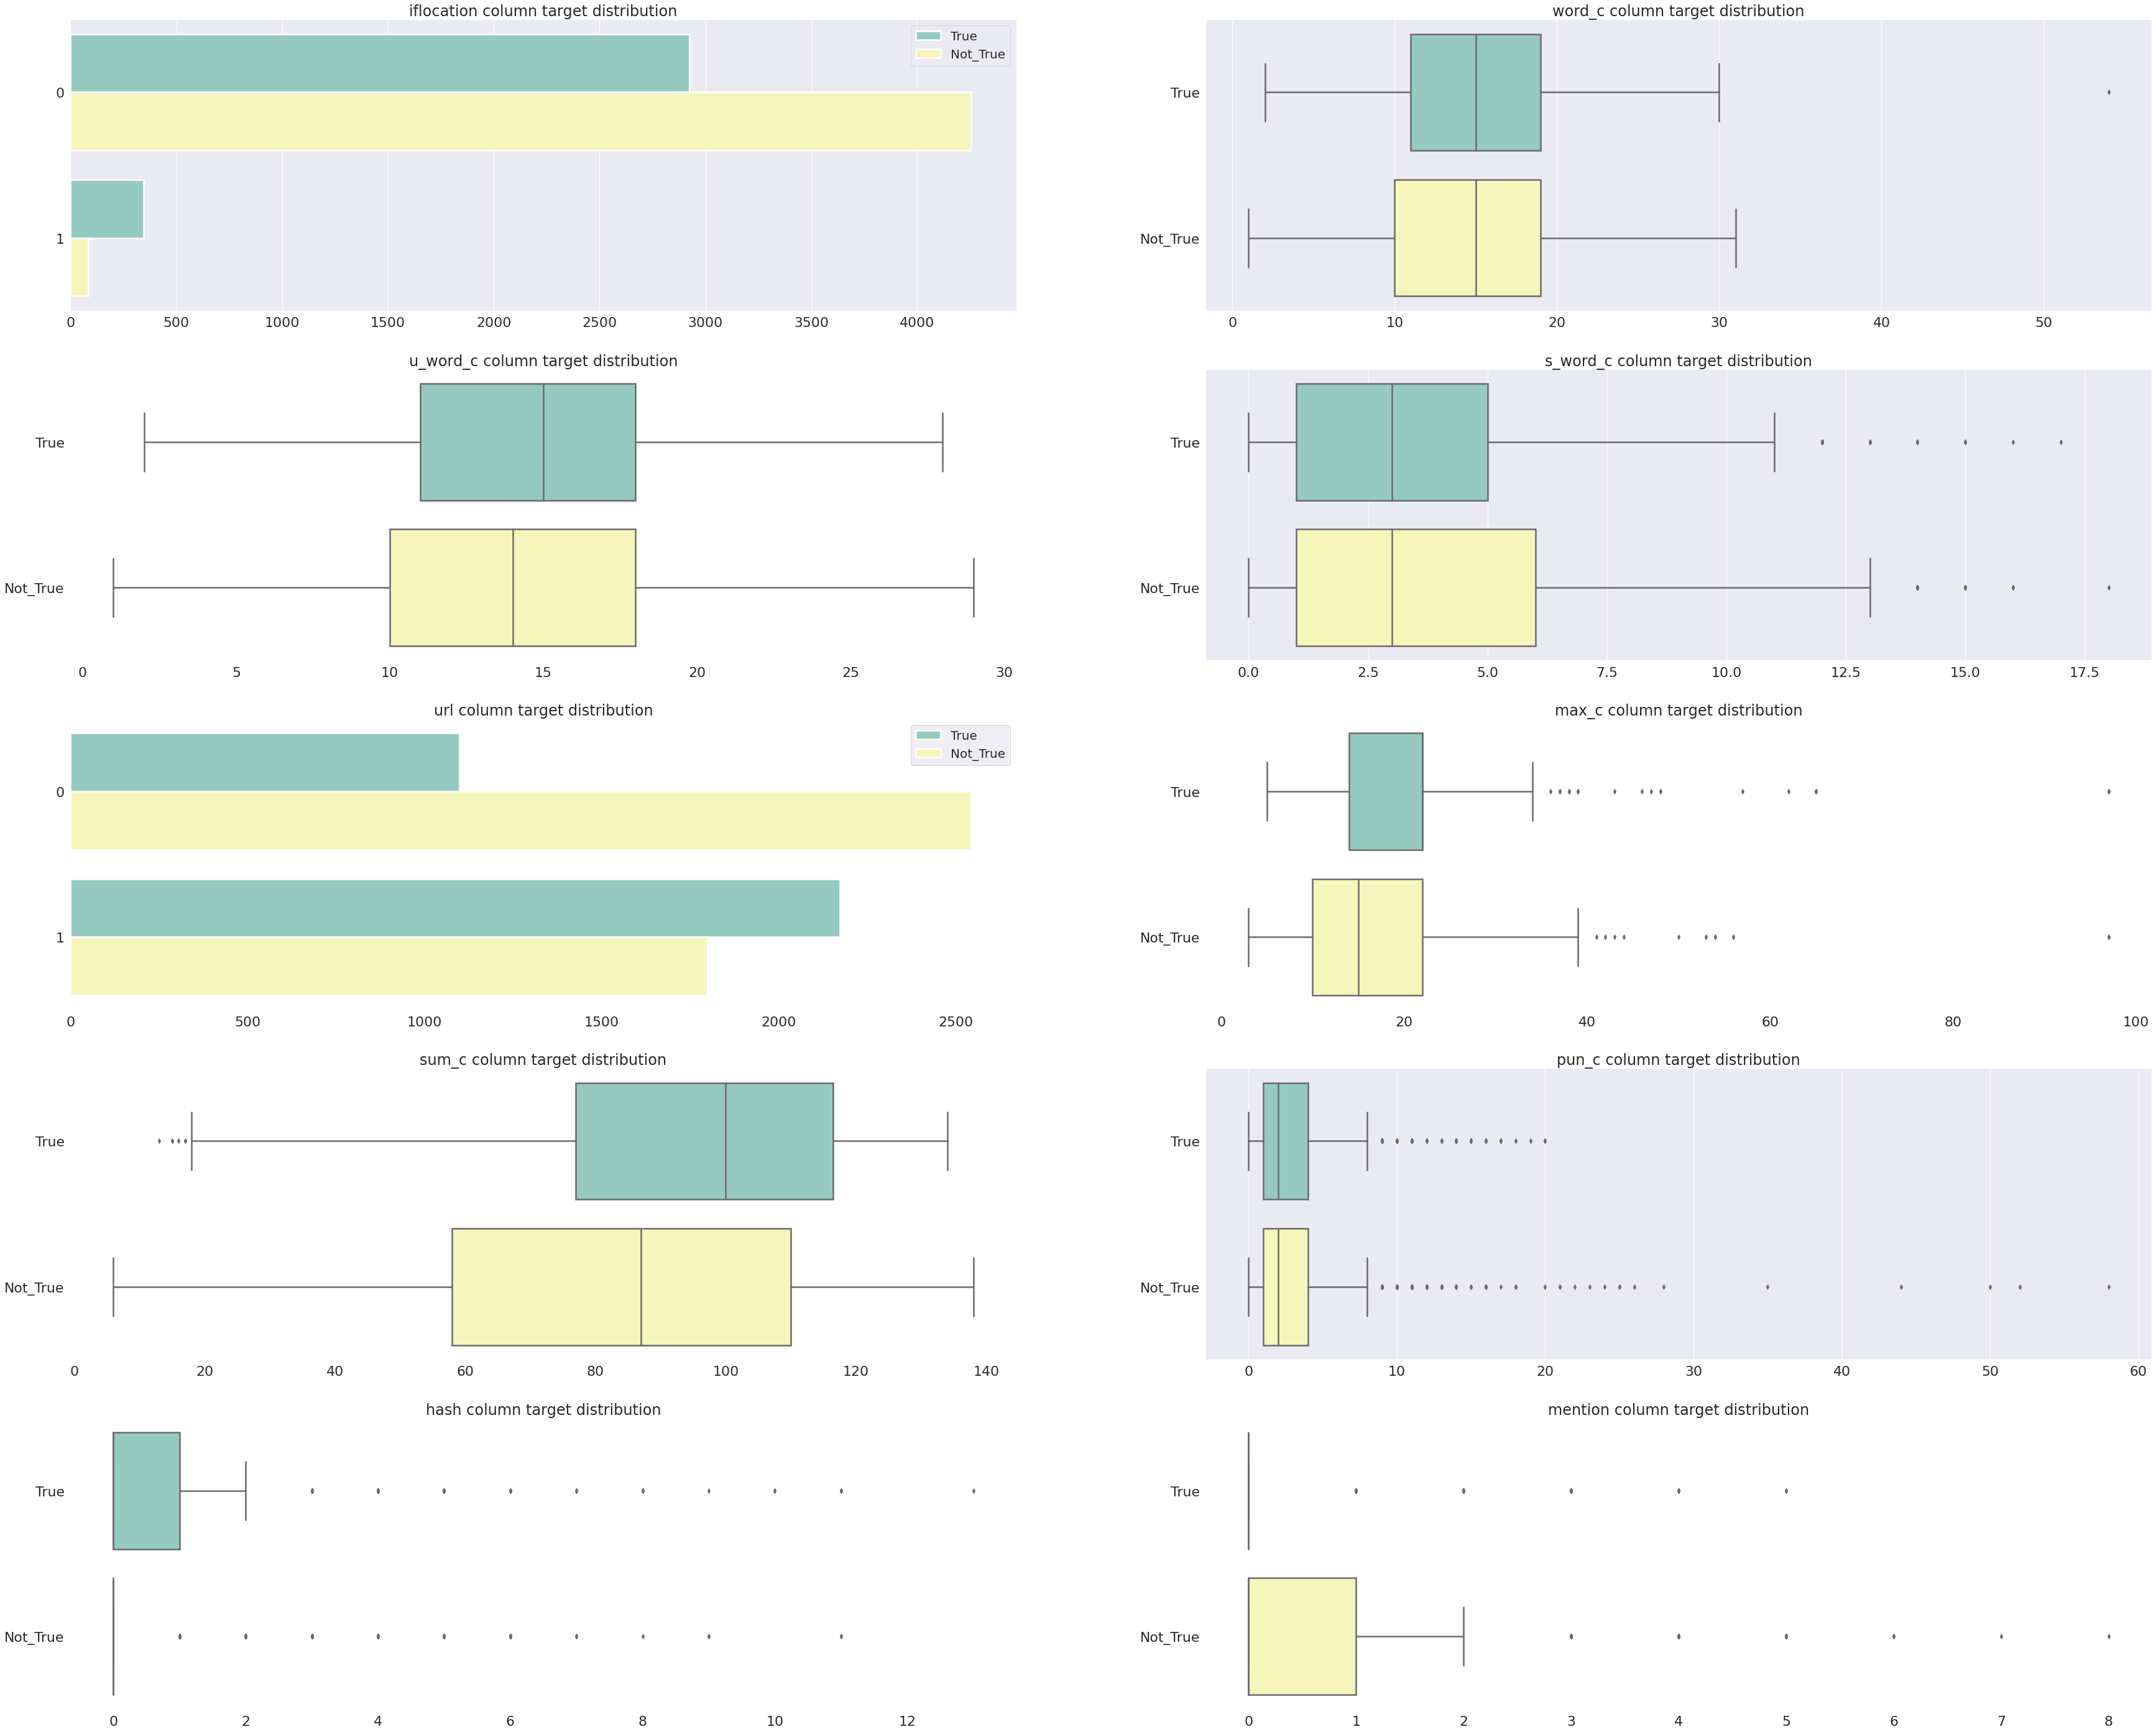

In [ ]:

sns.set(font_scale = 2)
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (60, 50))

row = 0
c = 0


for col in ['iflocation', 'word_c', 'u_word_c', 's_word_c', 'url', 'max_c', 'sum_c', 'pun_c', 'hash', 'mention']:
  if c > 1:
    c = 0
    row += 1
  
  
  if col in ['url', 'iflocation']:
    sns.countplot(data = train_fs, y = col,  linewidth=2.5, palette="Set3", ax = axes[row][c], hue = 'label')
    axes[row][c].legend(fontsize = 20)
    axes[row][c].set_ylabel('Without/ With',fontsize = 20)
    axes[row][c].set_xlabel('count',fontsize = 20)
  else:
    sns.boxplot(data = train_fs, y = 'label', x = col, linewidth=2.5, palette="Set3", ax = axes[row][c])

  axes[row][c].set_title('{} column target distribution'.format(col), fontweight = 10)
  axes[row][c].set_xlabel('')
  axes[row][c].set_ylabel('')

  if col not in ['location', 'u_word_c', 'url', 'max_c', 'sum_c', 'hash', 'mention']:    
    pass
  else:
    axes[row][c].set_facecolor('white')



  c += 1


plt.show()







['location', 'u_word_c', 'url', 'max_c', 'sum_c', 'hash', 'mention'], 在 label True和 label False兩群體間有明顯不同的分布，可以將這個數據作為有用的feature。

In [ ]:
train_fs = train_fs[['iflocation', 'u_word_c', 'url', 'max_c', 'sum_c', 'hash', 'mention']]

test_fs = test_fs[['iflocation', 'u_word_c', 'url', 'max_c', 'sum_c', 'hash', 'mention']]


# Text prepocessing 

根據https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings，在應用pre-trained w2v embedding時，應該要注意以下:


1.   別採用常規的text prepocessing程序，例如stemming或去除stopword，因為會流失掉有用的資訊
2.   Dataset中詞彙要盡量與embeddding中的詞彙相近



在這邊我採取的步驟為以下:



1.   Train和test合併，將text中的keyword與text合併，再拆解成詞彙，拆解後我們有173319個符號/詞彙
2.   計算詞彙/符號出現次數
3.   查看pretrained embedding(Google News)的覆蓋率
4.   清除或留下標點符號
5.   將數字以'#'取代
6.   簡化/ 修正錯字







####  1. 將句子拆解成詞彙



In [ ]:
train['text_key'] = [ t if str(k) == 'nan' else str(k) + ' ' + str(t) for k, t in zip(train['keyword'], train['text'])]
test['text_key'] = [ t if str(k) == 'nan' else str(k) + ' ' + str(t)  for k, t in zip(test['keyword'], test['text'])]

In [ ]:
# conbine train and test together

all_text = list(train.text_key) + list(test.text_key)
print('We got {} tweets.'.format(len(all_text)))

We got 10876 tweets.


In [ ]:
all_text_split = []
max_n_words = np.float('-inf')
n_words = 0

for s in all_text:
  words = s.split(' ')
  l = len(words)
  max_n_words = max(l, max_n_words)
  n_words += l
  
  all_text_split.append(words)

print(max_n_words, 'words from the longest sentence of all', len(all_text_split), 'tweets.')



55 words from the longest sentence of all 10876 tweets.


#### 2. 查看詞彙/符號出現的次數

In [ ]:
def word_occurance(text):
  # input: lists of lists of words
  # output: dict of words occurance, sorted by occurance

  d = {}

  for s in text:
    for w in s:

      if w not in d:
        d[w] = 1

      else:
        d[w] += 1
  
  print(len(d), 'unique words/punctuations.')

  d = dict(sorted(d.items(), key = lambda kv: kv[1], reverse = True))

  return d



In [ ]:
vocab_dict = word_occurance(all_text_split)

41922 unique words/punctuations.


In [ ]:
# Let's check what are the top 20 most frequent words
# Mostly stopwords like "the", "to", "a", "in", "and"
count = 0
for w, o in vocab_dict.items():
  print('word:', w, '|  occurance:', o, '|','percentage:', o/ n_words)
  print('__________________________________________________')
  count += 1
  if count > 20:
    break

word: the |  occurance: 3616 | percentage: 0.020863263692959225
__________________________________________________
word: to |  occurance: 2612 | percentage: 0.015070476981750415
__________________________________________________
word: a |  occurance: 2607 | percentage: 0.015041628442351964
__________________________________________________
word: in |  occurance: 2496 | percentage: 0.014401190867706368
__________________________________________________
word: of |  occurance: 2471 | percentage: 0.014256948170714117
__________________________________________________
word: and |  occurance: 1848 | percentage: 0.010662420161667215
__________________________________________________
word: I |  occurance: 1658 | percentage: 0.009566175664526106
__________________________________________________
word: is |  occurance: 1186 | percentage: 0.0068428735453124005
__________________________________________________
word: for |  occurance: 1130 | percentage: 0.006519769904049758
_______________________

#### 3. Google News embedding的覆蓋率

在任何更動前，覆蓋率為71.52%。

In [ ]:
def embedding_coverge(embedding, unique_words, n_words):
  
  in_e, out_e, vec, oov = 0, 0, {}, {}

  for w in unique_words:
    try:
      vec[w] = embedding[w]
      in_e += unique_words[w]
    except KeyError:
      oov[w] = unique_words[w]
      out_e += unique_words[w]

  print('{:.4%} words covered by embedding model.'.format(round(in_e/ n_words, 4)))
  print()
  print('{} words in embedding model which is {:.4%} of all unique words.'.format(len(vec), round(len(vec)/ len(unique_words), 4)))

  return in_e, out_e, vec, oov

  

    

In [ ]:
in_e, out_e, vec, oov = embedding_coverge(w2v, vocab_dict, n_words)

71.5200% words covered by embedding model.

17084 words in embedding model which is 40.7500% of all unique words.


#### 70.71% 詞彙,     40.79% 不重複詞彙被覆蓋。


以下是沒有在Google News pretrained embedding裡，前50個最常出現之詞彙/符號:

我們可以看到有一些是重複符號，可以將它修改成單一，或許pretrained embedding有相關的embedding vector。

In [ ]:
# check what words are out of embeddding
# to, a  words are removed from google news which makes sense.

# We can notice that many punctuations with no embedding vector.
# We need to further check, if a punctuation does not have embedding vector, then we discard it.
# for example, @ does have an vector, and we don't want to lose that information 


oov_sorted = sorted(oov.items(), key = lambda kv: kv[1], reverse = True)
oov_sorted[:50]


[('to', 2612),
 ('a', 2607),
 ('of', 2471),
 ('and', 1848),
 ('', 1080),
 ('-', 1062),
 ('??', 291),
 ('|', 200),
 ('...', 199),
 ('????', 137),
 ('@YouTube', 115),
 ('traumatised', 87),
 (':', 86),
 ('??????', 76),
 ('\x89Û_', 73),
 ('\x89ÛÒ', 65),
 ('?', 60),
 ('70', 56),
 ('/', 53),
 ('MH370:', 51),
 ('airplane%20accident', 50),
 ('blew%20up', 50),
 ('blown%20up', 50),
 ('body%20bag', 50),
 ('body%20bagging', 50),
 ('body%20bags', 50),
 ('bridge%20collapse', 50),
 ('buildings%20burning', 50),
 ('buildings%20on%20fire', 50),
 ('burning%20buildings', 50),
 ('cliff%20fall', 50),
 ('dust%20storm', 50),
 ('emergency%20plan', 50),
 ('emergency%20services', 50),
 ('fire%20truck', 50),
 ('first%20responders', 50),
 ('forest%20fires', 50),
 ('heat%20wave', 50),
 ('loud%20bang', 50),
 ('mass%20murder', 50),
 ('natural%20disaster', 50),
 ('nuclear%20disaster', 50),
 ('nuclear%20reactor', 50),
 ('oil%20spill', 50),
 ('structural%20failure', 50),
 ('suicide%20bomb', 50),
 ('suicide%20bomber', 50

## 清除或留下標點符號

找出哪些標點符號在pretrained embedding裡，留下那些標點符號，去除掉那些沒有的。

In [ ]:
# check what punctuations in w2v
punctuation_keep = ''

p = '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~'

for i in p:
  try:
    w2v[i]
    punctuation_keep = punctuation_keep + i
    #print(i)
  except KeyError:
    pass


這些是我們要留下的標點符號。

In [ ]:
punctuation_keep

'#$%*+=>@^_`~'

In [ ]:
import re

def clean_or_keep_punctuation(lists_of_words):
  # input: punctuations to be removed, list of lists of words
  # output: uninformative punctuation removed list of lists of words
  
  pun_cleaned = []
  
  for i in range(len(lists_of_words)):
    # some words not in embedding with this sentence(list)
    s = ' '.join(lists_of_words[i])
    
    # only keep #$%*+=>@^_`~, these punctuations

    tokens = re.findall(r"[\w']+|[#$%*+=>@^_`~]", s)

    pun_cleaned.append(tokens)

  return pun_cleaned




清除掉標點符號後，剩下的總不重複字數與符號為34427，7495個符號被清除。

In [ ]:
all_text_split_pun = clean_or_keep_punctuation(all_text_split)
pun_vocab_dict = word_occurance(all_text_split_pun)

34427 unique words/punctuations.


清除掉標點符號後，剩下的總字數與符號為207675(由於包括網址中的字符，所以會比原先多)。

In [ ]:
n_words_pun = sum([len(l) for l in all_text_split_pun])
print('Total words and punctuation: ',n_words_pun)

Total words and punctuation:  207675


清除掉標點符號後，從原本 70.71% 詞彙, 40.79%不重複詞彙的覆蓋率，上升到84.53%(+13.82% )詞彙，57.04%(+16.25%)不重複詞彙的覆蓋率。

In [ ]:
in_e_pun, out_e_pun, vec_pun, oov_pun = embedding_coverge(w2v, pun_vocab_dict,n_words_pun)

84.5300% words covered by embedding model.

19637 words in embedding model which is 57.0400% of all unique words.


#### 84.53% 詞彙,     57.04% 不重複詞彙被覆蓋。

In [ ]:
# check oov
# mostly numbers >= 10

sorted(oov_pun.items(), key = lambda kv: kv[1], reverse= True)[:60]

[('a', 2665),
 ('to', 2640),
 ('of', 2490),
 ('and', 1871),
 ('Û_', 512),
 ("'", 232),
 ('20fires', 138),
 ('Ûªs', 123),
 ('2015', 118),
 ('20up', 100),
 ('20storm', 100),
 ('20disaster', 100),
 ('traumatised', 98),
 ('MH370', 93),
 ('11', 86),
 ('10', 76),
 ('15', 75),
 ('20fire', 74),
 ('ÛÒ', 69),
 ('70', 63),
 ('08', 62),
 ('Ûª', 61),
 ('30', 59),
 ('20emergency', 59),
 ('40', 55),
 ('05', 51),
 ('00', 51),
 ('20accident', 50),
 ('20bag', 50),
 ('20bagging', 50),
 ('20bags', 50),
 ('20collapse', 50),
 ('20burning', 50),
 ('20on', 50),
 ('20buildings', 50),
 ('20fall', 50),
 ('20plan', 50),
 ('20services', 50),
 ('20truck', 50),
 ('20responders', 50),
 ('20wave', 50),
 ('20bang', 50),
 ('20murder', 50),
 ('20reactor', 50),
 ('20spill', 50),
 ('20failure', 50),
 ('20bomb', 50),
 ('20bomber', 50),
 ('20bombing', 50),
 ('20murderer', 46),
 ('ÛÓ', 45),
 ('Ûªt', 44),
 ('16yr', 42),
 ("Legionnaires'", 41),
 ('prebreak', 41),
 ('16', 40),
 ('01', 36),
 ("'The", 35),
 ('20zone', 35),
 ('06',

## 清除數字

根據 Dieter的文章- *How to: Preprocessing when using embeddings*, 我將會用"#"取代數字。

In [ ]:
def clean_numbers(list_lists_words):
  # input: list of lists of words
  # output: list of lists of words which numbers are replaced by "#"

  def number_replaced(x):
          
      x = re.sub('[0-9]{5,}', '#####', x)
      x = re.sub('[0-9]{4}', '####', x)
      x = re.sub('[0-9]{3}', '###', x)
      x = re.sub('[0-9]{2}', '##', x)      

      return x

  output = []
  for s in list_lists_words:
    o = list(map(number_replaced, s))
    output.append(o)

  return output    

處理數字後，剩下的總不重複字數與符號為34427，553個數字被清除。

In [ ]:
all_text_split_pun_num = clean_numbers(all_text_split_pun)
num_pun_vocab_dict = word_occurance(all_text_split_pun_num)

33874 unique words/punctuations.


處理數字後，剩下的總字數與符號為207675(維持不變)。

In [ ]:
n_words_pun_num = sum([len(l) for l in all_text_split_pun_num])
print(n_words_pun_num)

207675


清除掉標點符號後，從原本 84.53% 詞彙, 57.04%不重複詞彙的覆蓋率，上升到85.87%(+1.34% )詞彙，58.38%(+1.34%)不重複詞彙的覆蓋率。

In [ ]:
in_e_pun_num, out_e_pun_num, vec_pun_num, oov_pun_num = embedding_coverge(w2v, num_pun_vocab_dict,n_words_pun_num)

85.8700% words covered by embedding model.

19775 words in embedding model which is 58.3800% of all unique words.


#### 85.87%(+1.34% )詞彙，58.38%(+1.34%)不重複詞彙的覆蓋率。

In [ ]:
# some words have punctuations: "'"
# some words are misspellings 
# some words are contractions 


sorted(oov_pun_num.items(), key = lambda kv: kv[1], reverse = True)[:60]

[('a', 2665),
 ('to', 2640),
 ('of', 2490),
 ('and', 1871),
 ('Û_', 512),
 ("'", 232),
 ('##fires', 138),
 ('Ûªs', 123),
 ('##up', 100),
 ('##storm', 100),
 ('##disaster', 100),
 ('traumatised', 98),
 ('##fire', 74),
 ('ÛÒ', 69),
 ('Ûª', 61),
 ('##emergency', 59),
 ('##accident', 50),
 ('##bag', 50),
 ('##bagging', 50),
 ('##bags', 50),
 ('##collapse', 50),
 ('##burning', 50),
 ('##buildings', 50),
 ('##fall', 50),
 ('##plan', 50),
 ('##services', 50),
 ('##truck', 50),
 ('##responders', 50),
 ('##wave', 50),
 ('##bang', 50),
 ('##murder', 50),
 ('##reactor', 50),
 ('##spill', 50),
 ('##failure', 50),
 ('##bomb', 50),
 ('##bomber', 50),
 ('##bombing', 50),
 ('##murderer', 46),
 ('ÛÓ', 45),
 ('Ûªt', 44),
 ("Legionnaires'", 41),
 ('prebreak', 41),
 ("'The", 35),
 ('##zone', 35),
 ("'I", 32),
 ("'Conclusively", 30),
 ("Confirmed'", 30),
 ('Funtenna', 26),
 ("neighbour's", 26),
 ('ÛÏ', 25),
 ('Soudelor', 25),
 ('disea', 25),
 ("China's", 25),
 ("Reddit's", 24),
 ('subreddits', 24),
 ('best

## 縮寫、錯字/簡化處理

In [ ]:
# some words have punctuations: "'"
# some words are misspellings 
# some words are contractions 

def remove_apostrophe(list_lists_words):

  def check_first_last_char(word):

    if word[0] == "'":
      word = word[1:]
    elif word[-1] == "'":
      word = word[:-1]

    return word

  return [list(map(check_first_last_char, s)) for s in list_lists_words]
    


處理" ' "後，剩下的總不重複字數與符號為33285，1142個被清除。

In [ ]:
all_text_split_pun_num = remove_apostrophe(all_text_split_pun_num)
num_pun_vocab_dict = word_occurance(all_text_split_pun_num)


33285 unique words/punctuations.


處理" ' "後，剩下的總字數與符號為207675(維持不變)。

In [ ]:
n_words_pun_num = sum([len(l) for l in all_text_split_pun_num])
print(n_words_pun_num)

207675


In [ ]:
58.38-59.7

-1.3200000000000003

處理" ' "後，從原本85.87%詞彙,58.38%不重複詞彙的覆蓋率，上升到86.43%(+0.56% )詞彙，59.7%(+1.32%)不重複詞彙的覆蓋率。

In [ ]:
in_e_pun_num, out_e_pun_num, vec_pun_num, oov_pun_num = embedding_coverge(w2v, num_pun_vocab_dict,n_words_pun_num)

86.4300% words covered by embedding model.

19870 words in embedding model which is 59.7000% of all unique words.


#### 86.43%(+0.56% )詞彙，59.7%(+1.32%)不重複詞彙的覆蓋率。

In [ ]:

sorted(oov_pun_num.items(), key = lambda kv: kv[1], reverse = True)[:60]

[('a', 2666),
 ('to', 2640),
 ('of', 2490),
 ('and', 1872),
 ('Û_', 514),
 ('', 232),
 ('##fires', 138),
 ('Ûªs', 123),
 ('##up', 100),
 ('##storm', 100),
 ('##disaster', 100),
 ('traumatised', 98),
 ('##fire', 74),
 ('ÛÒ', 69),
 ('Ûª', 61),
 ('##emergency', 59),
 ('##accident', 50),
 ('##bag', 50),
 ('##bagging', 50),
 ('##bags', 50),
 ('##collapse', 50),
 ('##burning', 50),
 ('##buildings', 50),
 ('##fall', 50),
 ('##plan', 50),
 ('##services', 50),
 ('##truck', 50),
 ('##responders', 50),
 ('##wave', 50),
 ('##bang', 50),
 ('##murder', 50),
 ('##reactor', 50),
 ('##spill', 50),
 ('##failure', 50),
 ('##bomb', 50),
 ('##bomber', 50),
 ('##bombing', 50),
 ('##murderer', 46),
 ('ÛÓ', 45),
 ('Ûªt', 44),
 ('prebreak', 41),
 ('##zone', 35),
 ('Funtenna', 26),
 ("neighbour's", 26),
 ("China's", 26),
 ('ÛÏ', 25),
 ('Soudelor', 25),
 ('disea', 25),
 ("Reddit's", 24),
 ('subreddits', 24),
 ('bestnaijamade', 24),
 ('emmerdale', 23),
 ('GBBO', 22),
 ('colour', 19),
 ('Time####', 18),
 ('UTC####

In [ ]:
def simpling_vocab(list_lists_words):

  d = {'traumatised': 'traumatize', 
       'subreddits':'Reddit',
       'GBBO':'competition',
       'colour':'color',
       "Reddit's":'Reddit',
       'SCREAMED':'SCREAM',
       'Directioners':'fan',
       'Soudelor':'Typhoon',
       "neighbour's":'neighbor',
       "China's":'China',
       'disea':'disease',
       'NowPlaying':'playing',
       'MTVHottest':'MTV',
       'ArianaGrande':'singer',
       'Sismo':'earthquake',
       'MikeParrActor':'actor',
       'Beyhive':'fan',
       'Time####':'Time',
       'UTC####':'UTC',
       'ÛÏWhen':'When',
       'TrapMusic':'Music',
       '5SOS':'SOS',
       'usatoday':'news',
       'theatre':'theater',
       'WITHER':'wither',
       'realise':'realize',
       'animalrescue':'rescue',
       "Parley's":'Parleys',
       'USAgov':'government',
       'StrategicPatience':'patience',
       "Disney's":'Disney',
        '##fires':'fires',
        '##up': 'up',
      '##storm': 'storm',
      '##disaster': 'disaster',
       '##fire' : 'fire',
      '##emergency': 'emergency',
      '##accident': 'accident',
      '##bag':'bag',
      '##bagging':'bagging',
      '##bags': 'bags',
      '##collapse': 'collapse',
      '##burning': 'burning',
      '##buildings' : 'buildings',
      '##fall': 'fall',
      '##plan': 'plan',
      '##services': 'services',
      '##truck': 'truck',
      '##responders': 'responders',
      '##wave':'wave',
      '##bang':'bang',
      '##murder': 'murder',
      '##reactor': 'reactor',
      '##spill': 'spill',
      '##failure':'failure',
      '##bomb': 'bomb',
      '##bomber': 'bomber',
      '##bombing': 'bombing',
      '##murderer': 'murderer',
      '##zone':'zone',
       "I'M": 'I',
       
       }


  return [list(map(lambda x: d[x] if x in d else x, s)) for s in list_lists_words]





處理錯字/簡化後，剩下的總不重複字數與符號為33231，45個被清除。

In [ ]:
all_text_split_pun_num = simpling_vocab(all_text_split_pun_num)
num_pun_vocab_dict = word_occurance(all_text_split_pun_num)


33231 unique words/punctuations.


處理錯字/簡化後，剩下的總字數與符號為207675(維持不變)。

In [ ]:
n_words_pun_num = sum([len(l) for l in all_text_split_pun_num])
print(n_words_pun_num)

207675


處理錯字/簡化後，從原本86.43%詞彙,59.7%不重複詞彙的覆蓋率，上升到87.51% (+1.0799% )詞彙，59.81%(+0.1099%)不重複詞彙的覆蓋率。

In [ ]:
in_e_pun_num, out_e_pun_num, vec_pun_num, oov_pun_num = embedding_coverge(w2v, num_pun_vocab_dict,n_words_pun_num)

87.5100% words covered by embedding model.

19877 words in embedding model which is 59.8100% of all unique words.


#### 87.51% (+1.0799% )詞彙，59.81%(+0.1099%)不重複詞彙的覆蓋率。

In [ ]:
sorted(oov_pun_num.items(), key = lambda kv: kv[1], reverse = True)[:10]

[('a', 2666),
 ('to', 2640),
 ('of', 2490),
 ('and', 1872),
 ('Û_', 514),
 ('', 232),
 ('Ûªs', 123),
 ('ÛÒ', 69),
 ('Ûª', 61),
 ('ÛÓ', 45)]

去除" 's "後，剩下的總不重複字數與符號為33231，234個被清除。

In [ ]:
all_text_split_pun_num_clean = [[w[:-2] if w[-2:] == "'s" else w for w in s ] for s in all_text_split_pun_num]


In [ ]:
clean_num_pun_vocab_dict = word_occurance(all_text_split_pun_num_clean)


32997 unique words/punctuations.


去除" 's "後，剩下的總字數與符號為207675(維持不變)。

In [ ]:
n_words_pun_num_clean = sum([len(l) for l in all_text_split_pun_num_clean])
print(n_words_pun_num_clean)

207675


處理錯字/簡化後，從原本87.51%詞彙,59.81%不重複詞彙的覆蓋率，上升到87.69% (+0.1799% )詞彙，60.34%(+0.53%)不重複詞彙的覆蓋率。

In [ ]:
in_e_pun_num_c, out_e_pun_num_c, vec_pun_num_c, oov_pun_num_c = embedding_coverge(w2v, clean_num_pun_vocab_dict,n_words_pun_num_clean)

87.6900% words covered by embedding model.

19912 words in embedding model which is 60.3400% of all unique words.


#### 87.69% (+0.1799% )詞彙，60.34%(+0.53%)不重複詞彙的覆蓋率。

## 去除 OOV 詞彙

In [ ]:
print(sum([len(s) for s in all_text_split_pun_num_clean]), 'words in all_text_split_pun_num_clean')
print('Removing OOV words....')
all_text_split_pun_num_oov_clean = [[ w for w in s if w not in oov_pun_num_c] for s in all_text_split_pun_num_clean]
print(sum([len(s) for s in all_text_split_pun_num_oov_clean]), 'words in all_text_split_pun_num_oov_clean')


207675 words in all_text_split_pun_num_clean
Removing OOV words....
182118 words in all_text_split_pun_num_oov_clean


# Convert the word embedding into tokenized vector

因為某種原因, Keras的Tokenizer沒有辦法將某些字轉變成數字,所以我用自己的function(根據詞彙/符號在unique_words(list)的index為代碼)。

In [ ]:
# from tensorflow.python.keras.preprocessing.text import Tokenizer
# from tensorflow.python.keras.preprocessing.sequence import  pad_sequences

# token_dict = Tokenizer()
# token_dict.fit_on_texts(all_text_split_pun_num_oov_clean)

# seqs = token_dict.texts_to_sequences(all_text_split_pun_num_oov_clean)

In [ ]:
unique_words = list(vec_pun_num_c.keys())

In [ ]:
def assign_index(list_lists_words, unique_words):
  return [[ unique_words.index(w)+1 for w in s] for s in list_lists_words]
 

In [ ]:
seq = assign_index(all_text_split_pun_num_oov_clean, unique_words)
print('Check out the last text:')
print(seq[-1])
print(all_text_split_pun_num_oov_clean[-1])
print('Is the same length?', len(seq[-1]) == len(all_text_split_pun_num_oov_clean[-1]))

Check out the last text:
[4, 46, 2984, 355, 1890, 164, 1117, 4]
['#', 'has', 'activated', 'its', 'Municipal', 'Emergency', 'Plan', '#']
Is the same length? True


#### Dataset中最長的句子長度為36個字。 

In [ ]:
max_len = max([len(s) for s in seq])
max_len

36

#### Padding sequences 以確保每個sequence為同樣長度(36)。

In [ ]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

seq_pad = pad_sequences(seq, maxlen= max_len)

seq_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,  718, 6465,   26,    6, 3068,   28,    4,  211, 1041, 6466,
       6467,  212,   56], dtype=int32)

In [ ]:
print('Features of whole dataset: ', seq_pad.shape)

Features of whole dataset:  (10876, 36)


# Mapping embeddings from the pretrained w2v model and creating a matrix with word vectors.

## Embedding matrix有 19913 列(包括padding的0), 300欄。

In [ ]:
#  +1 is including zero
n_tokens = len(unique_words) + 1       


# embedding dimension 
vec_len = len(w2v['Taiwan'])

embedding_matrix = np.zeros((n_tokens, vec_len))


idx = 1
for w, vec in vec_pun_num_c.items():
  v = vec
  embedding_matrix[idx] = v
  idx += 1

In [ ]:
print('Matrix with word vectors, ', len(embedding_matrix), 'rows', len(embedding_matrix[0]), 'cols')

Matrix with word vectors,  19913 rows 300 cols


# 分割成 Training, Validation, Test 三部分

In [ ]:
# What is the training data size:  7613
# What is the test data size:  3263

Train & Test dataset split

In [ ]:
## split data into training, validation, and test data (features and labels, x and y)
## 7613 rows is the size of training dataset.

train_x = seq_pad[:7613, :]
test_x = seq_pad[7613:, :]

print('Train_x Size :{} , Test_x Size :{}'.format(train_x.shape, test_x.shape))

train_y = list(train.target)[:]

print('Train_y Size :{} '.format(len(train_y)))

Train_x Size :(7613, 36) , Test_x Size :(3263, 36)
Train_y Size :7613 


合併其他特徵。

In [ ]:
a = np.array(train_key_f_p[:7613]).reshape(-1, 1)
b = np.array(train_key_f_n[:7613]).reshape(-1, 1)
df_train_x = np.concatenate([a, b, np.array(train_fs.iloc[:7613, :])], axis= 1)


合併text feature和其他特徵，總特徵數為45。

In [ ]:
df_train_x = np.concatenate([train_x, df_train_x], axis= 1)
df_train_x.shape

(7613, 45)

In [ ]:
a = np.array(test_key_f_p[:7613]).reshape(-1, 1)
b = np.array(test_key_f_n[:7613]).reshape(-1, 1)
df_test_x = np.concatenate([a, b, np.array(test_fs.iloc[:7613, :])], axis= 1)
df_test_x = np.concatenate([test_x, df_test_x], axis= 1)

我選用隨機抽取 20% 的training dataset 作為validation dataset。

In [ ]:
from sklearn.model_selection import train_test_split

val_ratio = 0.2
train_x, val_x, train_y, val_y = train_test_split(df_train_x, train_y, test_size = val_ratio, random_state= 0, shuffle = True) 
train_x, val_x = train_x[:7600, :] ,  val_x[:7600, :]
train_y, val_y = train_y[:7600] , val_y[:7600]




## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTrain_y set: \t\t{}".format(len(train_y)))

			Feature Shapes:
Train set: 		(6090, 45) 
Validation set: 	(1523, 45) 
Train_y set: 		6090


# Using trained embedding vector in embedding layer


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from tensorflow.keras.layers import Bidirectional

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# Multiple Inputs Model(text feature + other features)

In [ ]:
# text_in = Input(shape=(embedding_matrix.shape[1],) 最長的tweets(修改後)長度, 36
# meta_in = 其他特徵數, 9

In [ ]:
def predict_submission(model, test_x):
  # if possibility > 0.5, Ture, else, Fake

  pred = model.predict({'emb':  np.array(test_x)[:, :36],'meta':  np.array(test_x)[:, -9:]} )  
  predict = [1 if p >= 0.5 else 0 for p in pred]
  df = pd.DataFrame({'id':list(test.id), 'target': predict})

  df.head()

  return df

####以下的model, Kaggle提交分數為: 0.78394

In [ ]:
nlp_input = keras.Input(shape=(max_len,), name='nlp_input')
meta_input = keras.Input(shape=(9,), name='meta_input')
 

emb = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], input_length= max_len, embeddings_initializer= Constant(embedding_matrix),  trainable = False)(nlp_input)
d1 = Dropout(0.8)(emb)
nlp_out = Bidirectional(LSTM(32, return_sequences=True))(d1)
d2 = Dropout(0.5)(nlp_out)
nlp_out2 = Bidirectional(LSTM(32))(d2)
x = layers.concatenate([nlp_out2, meta_input])
#x = Dense(classifier_neurons, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=[nlp_input , meta_input], outputs=[x])


In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nlp_input (InputLayer)          [(None, 36)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 36, 300)      5973900     nlp_input[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 36, 300)      0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 36, 64)       85248       dropout[0][0]                    
_______________________________________________________________________________________

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics = ['accuracy'])
model.fit({'emb':  np.array(train_x)[:, :36],'meta':  np.array(train_x)[:, 36:]} , np.array(train_y), validation_data= ({'emb':  np.array(val_x)[:, :36],'meta':  np.array(val_x)[:, 36:]}, np.array(val_y)), epochs=5 , batch_size= 30)

Epoch 1/5
203/203 [==============================] - 3s 16ms/step - loss: 1.3309 - accuracy: 0.5954 - val_loss: 0.5369 - val_accuracy: 0.7623
Epoch 2/5
203/203 [==============================] - 2s 11ms/step - loss: 0.5525 - accuracy: 0.7486 - val_loss: 0.4686 - val_accuracy: 0.7886
Epoch 3/5
203/203 [==============================] - 2s 11ms/step - loss: 0.5131 - accuracy: 0.7631 - val_loss: 0.4651 - val_accuracy: 0.7866
Epoch 4/5
203/203 [==============================] - 2s 11ms/step - loss: 0.4972 - accuracy: 0.7700 - val_loss: 0.4455 - val_accuracy: 0.8011
Epoch 5/5
203/203 [==============================] - 2s 11ms/step - loss: 0.4770 - accuracy: 0.7851 - val_loss: 0.4666 - val_accuracy: 0.7905


In [ ]:
meta1 = predict_submission(model, df_test_x)

In [ ]:
# meta1.to_csv('meta1.csv', index=False)

# LSTM model (One directional / Bidirectional LSTM Model)

In [ ]:
def predict_submission(model, test_x):
  pred = model.predict_classes(test_x)
  df = pd.DataFrame({'id':list(test.id), 'target':list(pred.reshape(-1,))})

  df.head()

  return df

### One Directional LSTM Model

####以下的model, Kaggle提交分數為: 0.76616

In [ ]:
# model structure 
# embeddings_initializer: 因為使用pretrained embedding layer, 所以參數要固定住


model = Sequential()
model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], embeddings_initializer= Constant(embedding_matrix), input_length= max_len, trainable = False))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics = ['accuracy'])

print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 36, 300)           5973900   
_________________________________________________________________
lstm_2 (LSTM)                (None, 36, 64)            93440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 36, 64)            33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 36, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [ ]:
h = model.fit(np.array(train_x), np.array(train_y), validation_data= (np.array(val_x), np.array(val_y)), epochs=5 , batch_size= 70)

Epoch 1/5
87/87 [==============================] - 1s 11ms/step - loss: 0.3090 - accuracy: 0.8760 - val_loss: 0.5804 - val_accuracy: 0.7912
Epoch 2/5
87/87 [==============================] - 1s 10ms/step - loss: 0.2990 - accuracy: 0.8828 - val_loss: 0.4818 - val_accuracy: 0.8030
Epoch 3/5
87/87 [==============================] - 1s 10ms/step - loss: 0.2832 - accuracy: 0.8882 - val_loss: 0.4779 - val_accuracy: 0.8076
Epoch 4/5
87/87 [==============================] - 1s 10ms/step - loss: 0.2645 - accuracy: 0.8913 - val_loss: 0.5274 - val_accuracy: 0.8050
Epoch 5/5
87/87 [==============================] - 1s 10ms/step - loss: 0.2661 - accuracy: 0.8934 - val_loss: 0.5310 - val_accuracy: 0.8083


In [ ]:
oned_5_e = predict_submission(model, test_x)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
oned_5_e.to_csv('oned_5e.csv', index=False)

### Birectional LSTM

#### 1 birectional LSTM layers


In [ ]:
model = Sequential()
model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], embeddings_initializer= Constant(embedding_matrix), input_length= max_len, trainable = False))
model.add(Dropout(0.55))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics = ['accuracy'])

h = model.fit(np.array(train_x), np.array(train_y), validation_data= (np.array(val_x), np.array(val_y)), epochs= 10 , batch_size= 50)

# average val_loss:  0.44612278540929157 average val_acc:  0.80521930

Epoch 1/10
122/122 [==============================] - 3s 23ms/step - loss: 0.5369 - accuracy: 0.7381 - val_loss: 0.4457 - val_accuracy: 0.7984
Epoch 2/10
122/122 [==============================] - 2s 15ms/step - loss: 0.4492 - accuracy: 0.7951 - val_loss: 0.4322 - val_accuracy: 0.8050
Epoch 3/10
122/122 [==============================] - 2s 13ms/step - loss: 0.4390 - accuracy: 0.8046 - val_loss: 0.4235 - val_accuracy: 0.8155
Epoch 4/10
122/122 [==============================] - 2s 13ms/step - loss: 0.4315 - accuracy: 0.8136 - val_loss: 0.4280 - val_accuracy: 0.8116
Epoch 5/10
122/122 [==============================] - 2s 15ms/step - loss: 0.4263 - accuracy: 0.8140 - val_loss: 0.4251 - val_accuracy: 0.8070
Epoch 6/10
122/122 [==============================] - 2s 14ms/step - loss: 0.4208 - accuracy: 0.8130 - val_loss: 0.4286 - val_accuracy: 0.8168
Epoch 7/10
122/122 [==============================] - 2s 14ms/step - loss: 0.4142 - accuracy: 0.8222 - val_loss: 0.4357 - val_accuracy: 0.8030

In [ ]:
print('average val_loss: ', np.average(h.history['val_loss']), 'average val_acc: ', np.average(h.history['val_accuracy']))

average val_loss:  0.4321111053228378 average val_acc:  0.8085357904434204


#### 2 layer bidirectional LSTM

#### 以下的model, Kaggle提交分數為:0.81060

In [ ]:
model = Sequential()
model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], embeddings_initializer= Constant(embedding_matrix), input_length= max_len, trainable = False))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, return_sequences=True, )))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics = ['accuracy'])

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 36, 300)           5973900   
_________________________________________________________________
dropout_14 (Dropout)         (None, 36, 300)           0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 36, 128)           186880    
_________________________________________________________________
dropout_15 (Dropout)         (None, 36, 128)           0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 6,259,725
Trainable params: 285,825
Non-trainable params: 5,973,900
______________________________________

In [ ]:
h = model.fit(np.array(train_x), np.array(train_y), validation_data= (np.array(val_x), np.array(val_y)), epochs=5 , batch_size= 50)

print('average val_loss: ', np.average(h.history['val_loss']), 'average val_acc: ', np.average(h.history['val_accuracy']))

Epoch 1/5
122/122 [==============================] - 3s 25ms/step - loss: 0.4966 - accuracy: 0.7667 - val_loss: 0.4509 - val_accuracy: 0.8030
Epoch 2/5
122/122 [==============================] - 2s 14ms/step - loss: 0.4376 - accuracy: 0.8084 - val_loss: 0.4335 - val_accuracy: 0.8050
Epoch 3/5
122/122 [==============================] - 2s 14ms/step - loss: 0.4309 - accuracy: 0.8131 - val_loss: 0.4275 - val_accuracy: 0.8089
Epoch 4/5
122/122 [==============================] - 2s 14ms/step - loss: 0.4195 - accuracy: 0.8172 - val_loss: 0.4196 - val_accuracy: 0.8148
Epoch 5/5
122/122 [==============================] - 2s 15ms/step - loss: 0.4087 - accuracy: 0.8202 - val_loss: 0.4268 - val_accuracy: 0.8096
average val_loss:  0.43164758682250975 average val_acc:  0.8082731485366821


In [ ]:
bilstm_2 = predict_submission(model, test_x)

In [ ]:
# bilstm_2.to_csv('/content/drive/My Drive/Kaggle/Real_or_Not/non_std_prep_2_bilstm.csv', index=False)

2 layer bidirectional LSTM, Try2

Kaggle score from 0.78394 to 0.79466

In [ ]:
model = Sequential()
model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], embeddings_initializer= Constant(embedding_matrix), input_length= max_len, trainable = False))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, return_sequences=True )))
model.add(Dropout(0.7))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics = ['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 36, 300)           5973900   
_________________________________________________________________
dropout_4 (Dropout)          (None, 36, 300)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 36, 128)           186880    
_________________________________________________________________
dropout_5 (Dropout)          (None, 36, 128)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,202,061
Trainable params: 228,161
Non-trainable params: 5,973,900
______________________________________

In [ ]:
h = model.fit(np.array(train_x), np.array(train_y), validation_data= (np.array(val_x), np.array(val_y)), epochs=8 , batch_size= 50)

print('average val_loss: ', np.average(h.history['val_loss']), 'average val_acc: ', np.average(h.history['val_accuracy']))

Epoch 1/8
122/122 [==============================] - 3s 22ms/step - loss: 0.5188 - accuracy: 0.7420 - val_loss: 0.4563 - val_accuracy: 0.7879
Epoch 2/8
122/122 [==============================] - 2s 13ms/step - loss: 0.4480 - accuracy: 0.8049 - val_loss: 0.4358 - val_accuracy: 0.8135
Epoch 3/8
122/122 [==============================] - 2s 13ms/step - loss: 0.4309 - accuracy: 0.8082 - val_loss: 0.4404 - val_accuracy: 0.8004
Epoch 4/8
122/122 [==============================] - 2s 13ms/step - loss: 0.4141 - accuracy: 0.8197 - val_loss: 0.4261 - val_accuracy: 0.8168
Epoch 5/8
122/122 [==============================] - 2s 13ms/step - loss: 0.4126 - accuracy: 0.8205 - val_loss: 0.4254 - val_accuracy: 0.8129
Epoch 6/8
122/122 [==============================] - 2s 13ms/step - loss: 0.3994 - accuracy: 0.8258 - val_loss: 0.4321 - val_accuracy: 0.8076
Epoch 7/8
122/122 [==============================] - 2s 13ms/step - loss: 0.3931 - accuracy: 0.8279 - val_loss: 0.4414 - val_accuracy: 0.8142
Epoch 

In [ ]:
# bilstm_2 = predict_submission(model, test_x)
# bilstm_2.to_csv('bilstm_2.csv', index=False)

#### 3 layer bidirectional LSTM

In [ ]:
# input: train_x => including keyword into text


# model structure 

model = Sequential()
model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], embeddings_initializer= Constant(embedding_matrix), input_length= max_len, trainable = False))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics = ['accuracy'])




h = model.fit(np.array(train_x[:, :36]), np.array(train_y), validation_data= (np.array(val_x[:, :36]), np.array(val_y)), epochs= 15 , batch_size= 50)

print('average val_loss: ', np.average(h.history['val_loss']), 'average val_acc: ', np.average(h.history['val_accuracy']))

# average val_loss:  0.42448173761367797 average val_acc:  0.8150579969088236

Epoch 1/15
122/122 [==============================] - 4s 30ms/step - loss: 0.4991 - accuracy: 0.7686 - val_loss: 0.4335 - val_accuracy: 0.8070
Epoch 2/15
122/122 [==============================] - 2s 17ms/step - loss: 0.4449 - accuracy: 0.7997 - val_loss: 0.4425 - val_accuracy: 0.8070
Epoch 3/15
122/122 [==============================] - 2s 17ms/step - loss: 0.4304 - accuracy: 0.8120 - val_loss: 0.4312 - val_accuracy: 0.8063
Epoch 4/15
122/122 [==============================] - 2s 17ms/step - loss: 0.4199 - accuracy: 0.8172 - val_loss: 0.4235 - val_accuracy: 0.8162
Epoch 5/15
122/122 [==============================] - 2s 17ms/step - loss: 0.4209 - accuracy: 0.8171 - val_loss: 0.4170 - val_accuracy: 0.8135
Epoch 6/15
122/122 [==============================] - 2s 16ms/step - loss: 0.4097 - accuracy: 0.8205 - val_loss: 0.4182 - val_accuracy: 0.8201
Epoch 7/15
122/122 [==============================] - 2s 17ms/step - loss: 0.4033 - accuracy: 0.8281 - val_loss: 0.4418 - val_accuracy: 0.8083

In [ ]:
# average val_loss:  0.42448173761367797 average val_acc:  0.8150579969088236

df_3_bilstm = predict_submission(model, test_x)

In [ ]:
df_3_bilstm.to_csv('_3_bilstm.csv', index = False)

####以下的model, Kaggle提交分數為:0.81673, 排名: 373/ 1313

In [ ]:

# model structure 


model = Sequential()
model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], embeddings_initializer= Constant(embedding_matrix), input_length= max_len, trainable = False))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics = ['accuracy'])




h = model.fit(np.array(train_x[:, :36]), np.array(train_y), validation_data= (np.array(val_x[:, :36]), np.array(val_y)), epochs= 15 , batch_size= 50)

print('average val_loss: ', np.average(h.history['val_loss']), 'average val_acc: ', np.average(h.history['val_accuracy']))


Epoch 1/15
122/122 [==============================] - 4s 32ms/step - loss: 0.5257 - accuracy: 0.7494 - val_loss: 0.4408 - val_accuracy: 0.7965
Epoch 2/15
122/122 [==============================] - 2s 17ms/step - loss: 0.4445 - accuracy: 0.8044 - val_loss: 0.4273 - val_accuracy: 0.8181
Epoch 3/15
122/122 [==============================] - 2s 17ms/step - loss: 0.4339 - accuracy: 0.8103 - val_loss: 0.4206 - val_accuracy: 0.8135
Epoch 4/15
122/122 [==============================] - 2s 18ms/step - loss: 0.4251 - accuracy: 0.8153 - val_loss: 0.4495 - val_accuracy: 0.8207
Epoch 5/15
122/122 [==============================] - 2s 18ms/step - loss: 0.4131 - accuracy: 0.8182 - val_loss: 0.4258 - val_accuracy: 0.8109
Epoch 6/15
122/122 [==============================] - 2s 18ms/step - loss: 0.4073 - accuracy: 0.8236 - val_loss: 0.4220 - val_accuracy: 0.8116
Epoch 7/15
122/122 [==============================] - 2s 17ms/step - loss: 0.4086 - accuracy: 0.8227 - val_loss: 0.4236 - val_accuracy: 0.8142

In [ ]:
# average val_loss:  0.4260603745778402 average val_acc:  0.8139198939005534
try2 = predict_submission(model, test_x)

In [ ]:
# try2.to_csv('try2.csv', index = False)